**Introduction**

##This notebook aims to build a deep learning model using MobileNetv2 for the classification of organoids.


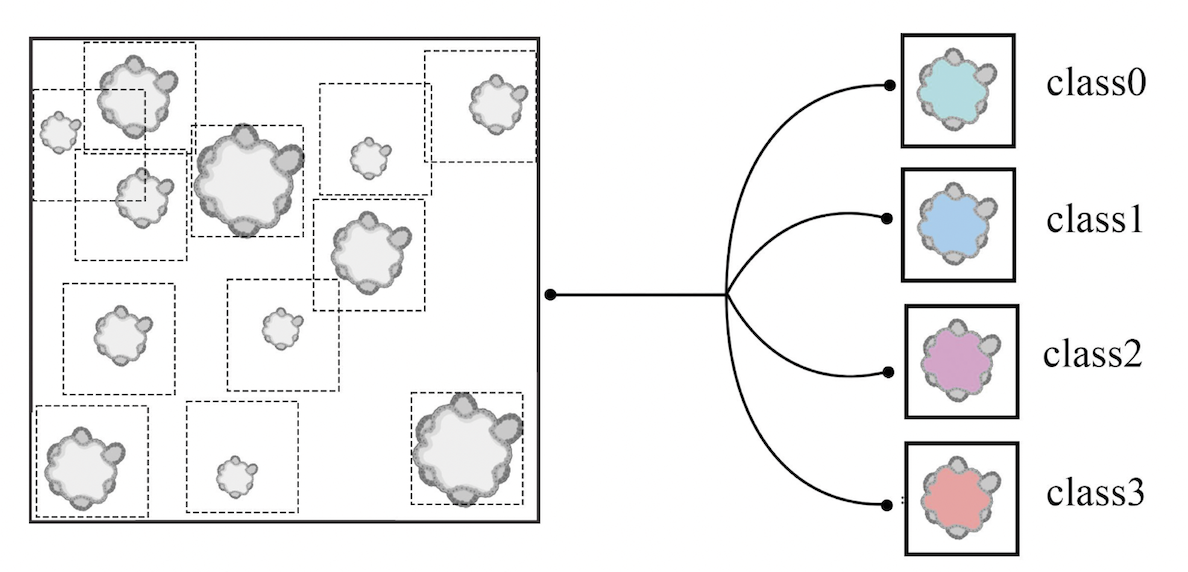
###The notebook consists of a group of code cells. To run them you have to press the play icon next to the cell to run and wait until the green check appears on the left of the code box.


## Table of Contents
1. [Data and Model Loading](#data_model_loading)
2. [Data Preprocessing](#data_preprocess)
3. [Model Training](#model_training)
4. [Model Evaluation](#evaluation)


# Data and Model Loading <a name="data_model_loading"></a>


In [ ]:
# Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Identify available GPU in the environment
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
# List all devices (CPUs and GPUs) accessible to TensorFlow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
# Import MobileNetV2 and preprocessing utilities from Keras applications
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np # Import NumPy for data manipulation

In [ ]:
#Initialize MobileNetV2 with ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Import Model class and necessary layers for constructing the neural network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Reference to the output of the base model
x = base_model.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a dense layer
x = Dense(512, activation='relu')(x)

# Add final dense layer for 4 classes with softmax activation
predictions = Dense(4, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the architecture of the model, including layer types and output shapes
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
# Import data preprocessing and augmentation tools for image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Keras optimizers for training the model
from keras import optimizers

# Import model frameworks and layers for building neural network architectures
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# Import callback utility to save the model at certain checkpoints during training
from keras.callbacks import ModelCheckpoint

In [ ]:
# training and validation folder paths
train_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/train_folder'
val_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/val_folder'

In [ ]:
# Set the batch size for training and number of training epochs
batch_size = 16
num_epochs = 40

# Data Preprocessing <a name="data_preprocess" />


In [ ]:
# Set up an image data generator with specified augmentations for model training
data_augmentation = ImageDataGenerator(
    rotation_range=20,       # Randomly rotate images within 20 degrees
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness between 80% and 120%
    width_shift_range=0.2,   # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    horizontal_flip=True,    # Randomly flip images horizontally
    zoom_range=0.2,          # Randomly zoom images by 20%
    fill_mode='nearest'      # Fill in new pixels created by rotation or width/height shift
)

In [ ]:
# Prepare the training data generator with augmentation, target size, batch size, and class mode
train_generator = data_augmentation.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# Prepare the validation data generator with augmentation, target size, batch size, and class mode
val_generator = data_augmentation.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 18537 images belonging to 4 classes.
Found 2058 images belonging to 4 classes.


# Model Training <a name="model_training"></a>


In [ ]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Set up the ModelCheckpoint callback to save only the best model based on the minimum validation loss
checkpoint_filepath = '/content/best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Set up the EarlyStopping callback for early stopping to prevent overfitting, with a patience of 10 epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True
)

# Start measuring time
start_time = time.time()


# Train the model with the training data generator and apply callbacks for checkpointing and early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback]  # Add both callbacks to the list
)

# Record the ending time for training and calculate the duration
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Print computational cost
print(f"Computational cost for model.fit: {computational_cost} seconds")

Epoch 1/40
1158/1158 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.7366 
Epoch 1: val_loss improved from inf to 3.72848, saving model to /content/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1158/1158 [==============================] - 17632s 15s/step - loss: 0.6650 - accuracy: 0.7366 - val_loss: 3.7285 - val_accuracy: 0.5156
Epoch 2/40
1158/1158 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.7855
Epoch 2: val_loss improved from 3.72848 to 3.68595, saving model to /content/best_model.h5
1158/1158 [==============================] - 280s 242ms/step - loss: 0.5378 - accuracy: 0.7855 - val_loss: 3.6859 - val_accuracy: 0.4810
Epoch 3/40
1158/1158 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.8079
Epoch 3: val_loss improved from 3.68595 to 0.87990, saving model to /content/best_model.h5
1158/1158 [==============================] - 281s 243ms/step - loss: 0.4926 - accuracy: 0.8079 - val_loss: 0.8799 - val_accuracy: 0.7144
Epoch 4/40
1158/1158 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8162
Epoch 4: val_loss improved from 0.87990 to 0.69604, saving model to /content/best_model.h5
1158/1158 [===========

In [ ]:
# Retrieve training and validation loss and accuracy from the history object for analysis
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

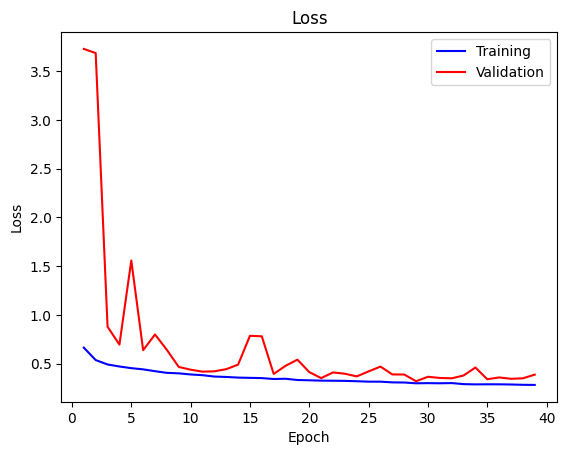

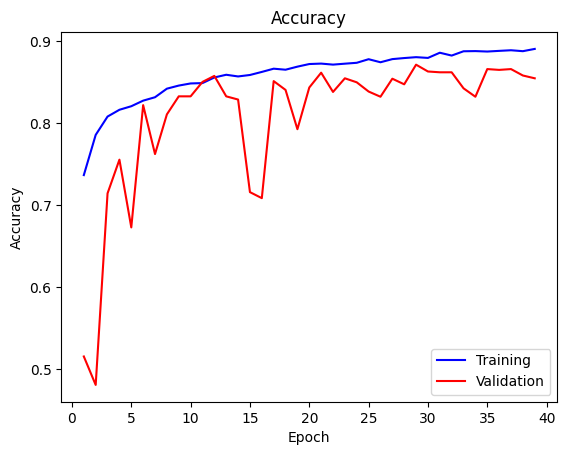

In [ ]:
import matplotlib.pyplot as plt

# Generate the range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot and save the loss figure with 600 DPI
plt.plot(epochs, train_loss, 'b-', label='Training')
plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('loss_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

# Plot and save the accuracy figure with 600 DPI
plt.plot(epochs, train_acc, 'b-', label='Training')
plt.plot(epochs, val_acc, 'r-', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('accuracy_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


# Model Evaluation <a name="evaluation"></a>


In [ ]:
# Import the ImageDataGenerator class for data preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory path for test data
test_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/test_folder'

# Initialize the ImageDataGenerator without augmentation for test data evaluation
test_datagen = ImageDataGenerator()

# Prepare the test data generator with specified target size, batch size, class mode, and without shuffling
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Data ordering will be preserved
)

Found 2468 images belonging to 4 classes.


In [ ]:
#testing

import time
import numpy as np
from keras.models import load_model

# Load the previously trained and saved best model
model_path = '/content/best_model.h5'
model = load_model(model_path)

# Measuring the time spent on loading data and making predictions
# Start measuring time
start_time = time.time()

# Load true labels for the test set from the generator
y_true = test_generator.classes  # Actual class labels

#Generate model predictions for the test set
y_pred = model.predict(test_generator)  # Model predictions

# Determine the class predictions based on the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels

# Record the ending time for prediction and calculate the duration
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Output the total time taken for the prediction process
print(f"Computational cost: {computational_cost} seconds")

In [ ]:
y_pred

array([[9.8175251e-01, 1.7321741e-03, 3.4051012e-05, 1.6481245e-02],
       [9.6725297e-01, 8.6896413e-04, 1.1060347e-05, 3.1867057e-02],
       [9.4785994e-01, 5.4305745e-03, 5.9877516e-04, 4.6110693e-02],
       ...,
       [3.9922532e-01, 5.0472718e-01, 1.4508331e-02, 8.1539176e-02],
       [6.7283094e-01, 4.1522551e-04, 5.8042486e-05, 3.2669574e-01],
       [5.8277196e-01, 1.8614521e-03, 6.9978320e-05, 4.1529664e-01]],
      dtype=float32)

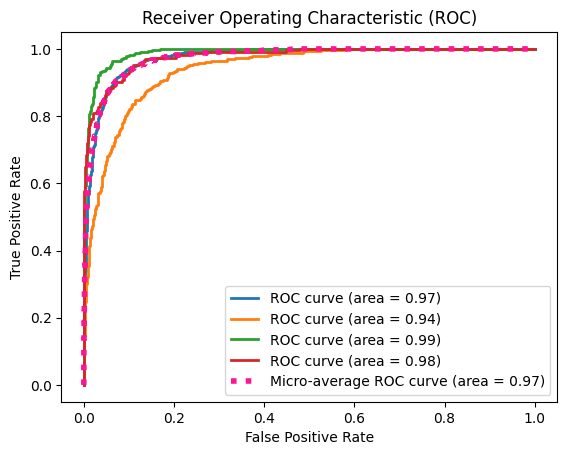

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# y_true contains true labels, and y_pred_classes contains predicted classes

# Binarize the true labels (one-hot encoding)
n_classes = len(np.unique(y_true))
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"],
         color='deeppink', linestyle=':', linewidth=4)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('roc_curves.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


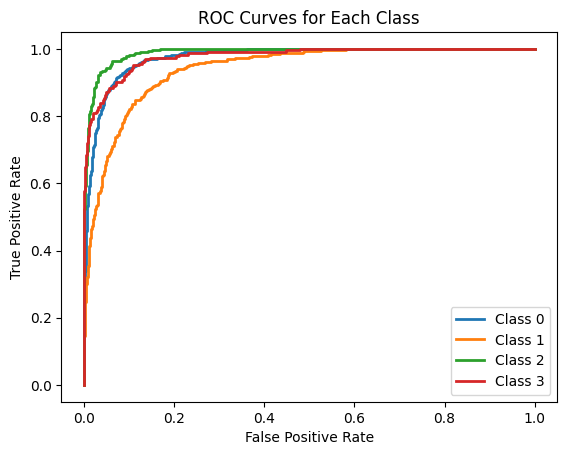

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize dictionaries to store FPR and TPR for each class
fpr_dict = {}
tpr_dict = {}

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=lw, label=f'Class {i}')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.savefig('roc_curves_for_class.png', format='png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

# Save FPR and TPR values to separate CSV files for each class
for i in range(n_classes):
    class_name = f'Class_{i}'
    fpr = fpr_dict[i]
    tpr = tpr_dict[i]

    # Save FPR and TPR values for the class to a CSV file
    with open(f'{class_name}_roc_curve.csv', 'w') as file:
        file.write('False Positive Rate, True Positive Rate\n')
        for j in range(len(fpr)):
            file.write(f'{fpr[j]}, {tpr[j]}\n')


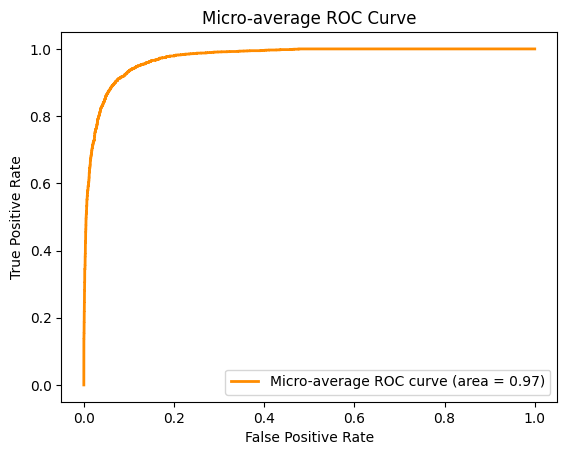

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the micro-average ROC curve
plt.figure()
lw = 2
plt.plot(fpr_micro, tpr_micro, color='darkorange',
         lw=lw, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.savefig('micro_avg_roc_curves.png', format='png', dpi=600, bbox_inches='tight')


# Show the plot
plt.show()

import pandas as pd

# Create a dataframe with fpr_micro and tpr_micro
df = pd.DataFrame({'fpr_micro': fpr_micro, 'tpr_micro': tpr_micro})

# Save the dataframe to a CSV file
df.to_csv('fpr_tpr_micro_values.csv', index=False)


In [ ]:
# Import classification metrics and confusion matrix functions from scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate the main classification metrics to evaluate the model's performance
accuracy = accuracy_score(y_true, y_pred_classes) # Overall accuracy of model predictions
precision = precision_score(y_true, y_pred_classes, average='weighted') # Precision score considering class imbalance
recall = recall_score(y_true, y_pred_classes, average='weighted') # Recall score considering class imbalance
f1 = f1_score(y_true, y_pred_classes, average='weighted') # Harmonic mean of precision and recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8541329011345219
Precision: 0.8588693785893111
Recall: 0.8541329011345219
F1-score: 0.8545037656766032


In [ ]:
# Calculate overall accuracy and the 'macro' average (unweighted mean across classes) for precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

# Output the computed performance metrics to the console
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8541329011345219
Precision: 0.8251071089133277
Recall: 0.8334993933662969
F1-score: 0.8262657164039504


In [ ]:
# Compute the confusion matrix for evaluating model performance
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix to analyze model predictions
print("Confusion Matrix:")
print(confusion_mtx)

In [ ]:
# Save the confusion matrix values to a text file (e.g., CSV)
with open('confusion_matrix.csv', 'w') as file:
    file.write("Confusion Matrix:\n")
    for row in confusion_mtx:
        file.write(','.join(map(str, row)) + '\n')

Confusion Matrix:
[[1161  105    1   27]
 [  36  395  116    1]
 [   0   22  378    1]
 [  40   11    0  174]]


In [ ]:
# Import NumPy for numerical operations and scikit-learn's roc_curve function for ROC curve analysis
import numpy as np
from sklearn.metrics import roc_curve

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize dictionaries to store FPR and TPR for each class
fpr_dict = {}
tpr_dict = {}

# Compute ROC curve for each class
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])

# Print TPR and FPR for each class
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"TPR (True Positive Rate): {tpr_dict[i]}")
    print(f"FPR (False Positive Rate): {fpr_dict[i]}")
    print()


Class 0:
TPR (True Positive Rate): [0.00000000e+00 7.72797527e-04 6.18238022e-02 6.18238022e-02
 7.95981453e-02 8.11437403e-02 2.54250386e-01 2.54250386e-01
 3.36939722e-01 3.36939722e-01 3.39258114e-01 3.39258114e-01
 3.85625966e-01 3.85625966e-01 4.56723338e-01 4.56723338e-01
 4.96908810e-01 4.96908810e-01 5.10046368e-01 5.10046368e-01
 5.31684699e-01 5.31684699e-01 5.47140649e-01 5.47140649e-01
 5.57187017e-01 5.57187017e-01 5.68006182e-01 5.68006182e-01
 5.90417311e-01 5.90417311e-01 5.91962906e-01 5.91962906e-01
 6.21329212e-01 6.21329212e-01 6.22874807e-01 6.22874807e-01
 6.23647604e-01 6.23647604e-01 6.35239567e-01 6.35239567e-01
 6.36012365e-01 6.36012365e-01 6.47604328e-01 6.47604328e-01
 6.73879444e-01 6.73879444e-01 6.79289026e-01 6.79289026e-01
 6.90880989e-01 6.90880989e-01 6.93972179e-01 6.93972179e-01
 7.07882535e-01 7.07882535e-01 7.10973725e-01 7.10973725e-01
 7.13292117e-01 7.13292117e-01 7.21792890e-01 7.21792890e-01
 7.36476043e-01 7.36476043e-01 7.50386399e-01 7.50

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# y_true contains true labels, and y_pred_classes contains predicted classes

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate classification report
classification_rep = classification_report(y_true, y_pred_classes)

# Calculate overall accuracy
accuracy = np.mean(y_true == y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print classification report
print("\nClassification Report:")
print(classification_rep)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy:.2%}")


Confusion Matrix:
[[1161  105    1   27]
 [  36  395  116    1]
 [   0   22  378    1]
 [  40   11    0  174]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1294
           1       0.74      0.72      0.73       548
           2       0.76      0.94      0.84       401
           3       0.86      0.77      0.81       225

    accuracy                           0.85      2468
   macro avg       0.83      0.83      0.83      2468
weighted avg       0.86      0.85      0.85      2468


Overall Accuracy: 85.41%


In [ ]:
from sklearn.metrics import confusion_matrix

# y_true contains true labels, and y_pred_classes contains predicted classes

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate sensitivity (TPR) and specificity for each class
sensitivity = []
specificity = []

for i in range(len(confusion_mtx)):
    true_positives = confusion_mtx[i, i]
    false_negatives = np.sum(confusion_mtx[i, :]) - true_positives
    true_negatives = np.sum(confusion_mtx) - np.sum(confusion_mtx[i, :]) - np.sum(confusion_mtx[:, i]) + true_positives
    false_positives = np.sum(confusion_mtx[:, i]) - true_positives

    sensitivity_i = true_positives / (true_positives + false_negatives)
    specificity_i = true_negatives / (true_negatives + false_positives)

    sensitivity.append(sensitivity_i)
    specificity.append(specificity_i)

# Print sensitivity and specificity for each class
for i in range(len(sensitivity)):
    print(f"Class {i}:")
    print(f"Sensitivity (True Positive Rate): {sensitivity[i]:.2f}")
    print(f"Specificity (True Negative Rate): {specificity[i]:.2f}")
    print()


Class 0:
Sensitivity (True Positive Rate): 0.90
Specificity (True Negative Rate): 0.94

Class 1:
Sensitivity (True Positive Rate): 0.72
Specificity (True Negative Rate): 0.93

Class 2:
Sensitivity (True Positive Rate): 0.94
Specificity (True Negative Rate): 0.94

Class 3:
Sensitivity (True Positive Rate): 0.77
Specificity (True Negative Rate): 0.99



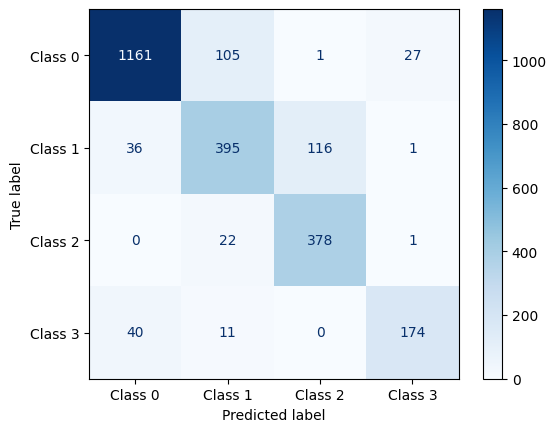

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# Display labels for the classes
display_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=display_labels)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)

# Save the figure as a PNG file
plt.savefig('cm_conf_4_classes.png', dpi=100)

# Show the plot
plt.show()


In [ ]:
confusion_mtx

array([[1161,  105,    1,   27],
       [  36,  395,  116,    1],
       [   0,   22,  378,    1],
       [  40,   11,    0,  174]])

In [ ]:
import numpy as np

# Define a function to print a confusion matrix in a formatted manner
def print_confusion_matrix(matrix):
    print("Confusion Matrix:")
    print("array(", end='')
    for i, row in enumerate(matrix):
        if i == 0:
            print("[", end='')
        else:
            print("       [", end='')

        for j, value in enumerate(row):
            end_char = ", " if j < len(row) - 1 else "]"
            print(f"{value:>4}", end=end_char)

        if i < len(matrix) - 1:
            print(",")
        else:
            print("])")

# Test
matrix =confusion_mtx
print_confusion_matrix(matrix)


Confusion Matrix:
array([1161,  105,    1,   27],
       [  36,  395,  116,    1],
       [   0,   22,  378,    1],
       [  40,   11,    0,  174]])


In [ ]:
import numpy as np

def compute_metrics(matrix):
    num_classes = matrix.shape[0]

    # True positives
    TP = np.diag(matrix)

    # False positives
    FP = matrix.sum(axis=0) - TP

    # False negatives
    FN = matrix.sum(axis=1) - TP

    # True negatives
    TN = matrix.sum() - (FP + FN + TP)

    # Accuracy
    overall_accuracy = TP.sum() / matrix.sum()

    # Sensitivity/Recall
    sensitivity = TP / (TP + FN)

    # Specificity
    specificity = TN / (TN + FP)

    # Precision
    precision = TP / (TP + FP)

    # F1 Score
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    return overall_accuracy, sensitivity, specificity, f1_score

# Test
matrix = confusion_mtx
overall_accuracy, sensitivity, specificity, f1_score = compute_metrics(matrix)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
for i in range(matrix.shape[0]):
    print(f"\nClass {i} metrics:")
    print(f"Sensitivity/Recall: {sensitivity[i]:.4f}")
    print(f"Specificity: {specificity[i]:.4f}")
    print(f"F1 Score: {f1_score[i]:.4f}")


Overall Accuracy: 0.8541

Class 0 metrics:
Sensitivity/Recall: 0.8972
Specificity: 0.9353
F1 Score: 0.9174

Class 1 metrics:
Sensitivity/Recall: 0.7208
Specificity: 0.9281
F1 Score: 0.7308

Class 2 metrics:
Sensitivity/Recall: 0.9426
Specificity: 0.9434
F1 Score: 0.8438

Class 3 metrics:
Sensitivity/Recall: 0.7733
Specificity: 0.9871
F1 Score: 0.8131


In [ ]:
import numpy as np

def compute_metrics(matrix):
    num_classes = matrix.shape[0]

    # True positives
    TP = np.diag(matrix)

    # False positives
    FP = matrix.sum(axis=0) - TP

    # False negatives
    FN = matrix.sum(axis=1) - TP

    # True negatives
    TN = matrix.sum() - (FP + FN + TP)

    # Accuracy
    overall_accuracy = TP.sum() / matrix.sum()

    # Micro-average Sensitivity/Recall
    micro_recall = TP.sum() / (TP.sum() + FN.sum())

    # Micro-average Precision
    micro_precision = TP.sum() / (TP.sum() + FP.sum())

    # Micro-average F1 Score
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    # Micro-average Specificity
    micro_specificity = TN.sum() / (TN.sum() + FP.sum())

    return overall_accuracy, micro_recall, micro_specificity, micro_f1_score

# Test
matrix = confusion_mtx

overall_accuracy, micro_recall, micro_specificity, micro_f1_score = compute_metrics(matrix)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Micro-average Sensitivity/Recall: {micro_recall:.4f}")
print(f"Micro-average Specificity: {micro_specificity:.4f}")
print(f"Micro-average F1 Score: {micro_f1_score:.4f}")


Overall Accuracy: 0.8541
Micro-average Sensitivity/Recall: 0.8541
Micro-average Specificity: 0.9514
Micro-average F1 Score: 0.8541


In [ ]:
y_pred

array([[9.8175251e-01, 1.7321741e-03, 3.4051012e-05, 1.6481245e-02],
       [9.6725297e-01, 8.6896413e-04, 1.1060347e-05, 3.1867057e-02],
       [9.4785994e-01, 5.4305745e-03, 5.9877516e-04, 4.6110693e-02],
       ...,
       [3.9922532e-01, 5.0472718e-01, 1.4508331e-02, 8.1539176e-02],
       [6.7283094e-01, 4.1522551e-04, 5.8042486e-05, 3.2669574e-01],
       [5.8277196e-01, 1.8614521e-03, 6.9978320e-05, 4.1529664e-01]],
      dtype=float32)

In [ ]:
y_true

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
# Select the index of the class with the highest probability for each example
predicted_classes = np.argmax(y_pred, axis=1)

# Create a DataFrame with the predicted classes
df_predictions = pd.DataFrame(predicted_classes, columns=['Predicted Class'])

# Save the DataFrame to an Excel file
df_predictions.to_excel('test_predictions_MobileNetv2.xlsx', index=False)
